# Down-scaled multi-area model

#### Notebook structure <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Paramters specification](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
    * [1.2. Default parameters](#section_1_2)
* [S2. Multi-area model instantiation and simulation](#section_2)
    * [2.1. Insantiate a multi-area model](#section_2_1)
    * [2.2. Predict firing rates from theory](#section_2_2)
    * [2.3. Extract interarea connectivity](#section_2_3)
    * [2.4. Run the simulation](#section_2_4)
* [S3. Simulation results validation and connection extraction](#section_3)
* [S4. Data loading and processing](#section_4)
* [S5. Simulation results visualization](#section_5) 
    * [5.1. Instantaneous and mean firing rate across all populations](#section_5_1)
    * [5.2. Raster plot of spiking activity for single area](#section_5_2)
    * [5.3. Population-averaged firing rate](#section_5_3)
    * [5.4 Time-averaged population rates](#section_5_4)
    * [5.5. Average pairwise correlation coefficients of spiking activity](#section_5_5)
    * [5.6. Irregularity of spiking activity](#section_5_6)
    * [5.7. Time series of population- and area-averaged firing rates](#section_5_7)

<br>

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [2]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import nest
from IPython.display import display, HTML
import json

# Import the MultiAreaModel class
from multiarea_model import MultiAreaModel
from multiarea_model import Analysis
from config import base_path, data_path


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: May 17 2023 20:48:31

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
!pip install nested_dict dicthash

In [4]:
# Jupyter notebook display format setting
style = """
<style>
table {float:left}
</style>
"""
display(HTML(style))

Go back to [Notebook structure](#toc)

<br>

## S1. Paramters specification <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

|Parameter                     |Default value            |Value range/options                                                   |Value assigned      |Description  |
|:----------------------------:|:-----------------------:|:--------------------------------------------------------------------:|:------------------:|:-----------:|
|scale_down_to                 |1.                       |(0, 1.]                                                               |0.005               |$^1$         |
|cc_weights_factor             |1.                       |(0, 1.]                                                               |1.                  |$^2$         |
|areas_simulated               |complete_area_list       |All sublists of complete_area_list                                    |complete_area_list  |$^3$         |
|replace_non_simulated_areas   |None                     |None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'   |'het_poisson_stat'  |$^4$         |

1. `scale_down_to` <br>
`scale_down_to` is the down-scaling factor which defines the the ratio of the full scale multi-area model being down-scaled to a model with fewer neurons and indegrees so as to be simulated on machines with lower computational ability and the simulation results can be obtained within relative shorter period of time. <br> Its deafualt value if `1.` meaning full scale simulation. <br> In the pre-set downscale version, it's set as `0.005`, where the numer of neurons and indegrees are both scaled down to 0.5% of its full scale amount, where the model can usually be simulated on a local machine. <br> **Warning**: This will not yield reasonable dynamical results from the network and is only meant to demonstrate the simulation workflow <br> 
2. `cc_weights_factor` <br>
This scaling factor controls the cortico-cortical synaptic strength. <br> By default it's set as `1.0`, where the inter-area synaptic strength is the same as the intra-areal. <br> **Important**: This factor changes the network activity from ground state to metastable state. <br>
3. `areas_simulated` <br>
This parameter specifies the cortical areas included in the simulation process. Its default value is `complete_area_list` meaning all the areas in the complete_area_list will be actually simulated. <br>
complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH'] <br>
The value assigned to simulation_areas can be any sublist of the compete_area_list specifying areas a user want to include in his/her simulation. <br>
4. `replace_non_simulated_areas` <br>
The paramter `replace_non_simulated_areas` defines how non-simulated areas will be replaced. <br> It's set as `None` by default when the parameter areas_simulated is set as full_area_list where all areas will be simulated so that no areas need to be replaced. <br> Other options are: `'hom_poisson_stat'`, `'het_poisson_stat'`, and `'het_current_nonstat'`. `'hom_poisson_stat'` is a manually set parameter which can be tuned. When it's set as 'het_poisson_stat' or 'het_current_nonstat', the data to replace the cortico-cortical input is loaded from 'replace_cc_input_source' which is the firing rates of our full scale simulation results. The differenc between 'het_poisson_stat' and 'het_current_nonstat' is that 'het_poisson_stat' is the mean of the time-series firing rate so that it's static, yet 'het_current_nonstat' is time-varying specific current, which is varying by time. 

In [5]:
# Downscaling factor
scale_down_to = 0.005 # Change it to 1. for running the fullscale network

# Scaling factor for cortico-cortical connections (chi) 
cc_weights_factor = 1.

# Cortical areas included in the simulation
areas_simulated = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']

# Firing rates used to replace the non-simulated areas
replace_non_simulated_areas = 'het_poisson_stat'

### 1.2. Default parameters <a class="anchor" id="section_1_2"></a>
We try our best not to confuse users with too many parameters. However, if you want to change more parameters and explore the model, you can do so by passing a dictionary to the `default_params` argument of the `MultiAreaModel` class.

In [6]:
# Connection parameters
conn_params = {
    'replace_non_simulated_areas': 'het_poisson_stat', # Whether to replace non-simulated areas by Poisson sources with the same global rate, by default: None
    'g': -11., # It sets the relative inhibitory synaptic strength, by default: -16.
    'K_stable': 'K_stable.npy', # Whether to apply the stabilization method of Schuecker, Schmidt et al. (2017), by default: None
    'fac_nu_ext_TH': 1.2, # Increase the external input to 2/3E and 5E in area TH
    'fac_nu_ext_5E': 1.125, # Increase the external Poisson indegree onto 5E
    'fac_nu_ext_6E': 1.41666667, # Increase the external Poisson indegree onto 6E
    'av_indegree_V1': 3950. # Adjust the average indegree in V1 based on monkey data
}

# Input parameters
input_params = {
    'rate_ext': 10. # Rate of the Poissonian spike generator (in spikes/s)
} 

# Neuron parameters
neuron_params = {
    'V0_mean': -150., # Mean for the distribution of initial membrane potentials, by default: -100.
    'V0_sd': 50.} # Standard deviation for the distribution of initial membrane potentials, by default: 50.

# Network parameters
network_params = {
    'N_scaling': scale_down_to, # Scaling of population sizes, by default: 1.
    'K_scaling': scale_down_to, # Scaling of indegrees, by default: 1.
    'fullscale_rates': 'tests/fullscale_rates.json', # Absolute path to the file holding full-scale rates for scaling synaptic weights, by default: None
    'input_params': input_params, # Input parameters
    'connection_params': conn_params, # Connection parameters
    'neuron_params': neuron_params # Neuron parameters
} 

# Simulation parameters
sim_params = {
    'areas_simulated': areas_simulated,
    't_sim': 2000., # Simulated time (in ms), by default: 10.0
    'num_processes': 1, # The number of MPI processes, by default: 1
    'local_num_threads': 1, # The number of threads per MPI process, by default: 1
    'recording_dict': {'record_vm': False},
    'rng_seed': 1  # global random seed
}

# Theory paramters (theory_params)
theory_params = {
    'dt': 0.1 # The time step of the mean-field theory integration, by default: 0.01
} 

Go back to [Notebook structure](#toc)

<br>

## S2. Multi-area model instantiation and simulation <a class="anchor" id="section_2"></a>

### 2.1. Insantiate a multi-area model <a class="anchor" id="section_2_1"></a>

In [7]:
M = MultiAreaModel(network_params, 
                   simulation=True,
                   sim_spec=sim_params,
                   theory=True,
                   theory_spec=theory_params)

Initializing network from dictionary.
RAND_DATA_LABEL 2610


/srv/main-spack-instance-2302/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.21.6-6fewtq7oarp3vtwlxrrcofz5sxwt55s7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:Mean of empty slice.
/srv/main-spack-instance-2302/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.21.6-6fewtq7oarp3vtwlxrrcofz5sxwt55s7/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning:invalid value encountered in double_scalars
Error in library("aod") : there is no package called ‘aod’
Execution halted


No R installation or IndexError, taking hard-coded SLN fit parameters.


Customized parameters
--------------------
{'K_scaling': 0.005,
 'N_scaling': 0.005,
 'connection_params': {'K_stable': 'K_stable.npy',
                       'av_indegree_V1': 3950.0,
                       'fac_nu_ext_5E': 1.125,
                       'fac_nu_ext_6E': 1.41666667,
                       'fac_nu_ext_TH': 1.2,
                       'g': -11.0,
                       'replace_non_simulated_areas': 'het_poisson_stat'},
 'fullscale_rates': 'tests/fullscale_rates.json',
 'input_params': {'rate_ext': 10.0},
 'neuron_params': {'V0_mean': -150.0, 'V0_sd': 50.0}}


/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/dicthash/dicthash.py:47: UserWarning:Float too small for safe conversion tointeger. Rounding down to zero.


Simulation label: 27d81076e6d6e9e591684be053078477
Copied files.
Initialized simulation class.


### 2.2. Predict firing rates from theory <a class="anchor" id="section_2_2"></a>

In [8]:
p, r = M.theory.integrate_siegert()
print("Mean-field theory predicts an average "
      "firing rate of {0:.3f} spikes/s across all populations.".format(np.mean(r[:, -1])))

Iteration: 0
Mean-field theory predicts an average firing rate of 29.588 spikes/s across all populations.


### 2.3. Extract interarea connectivity <a class="anchor" id="section_2_3"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. Neuron numbers are stored in `M.N` as a dictionary (and in `M.N_vec` as an array), indegrees in `M.K` as a dictionary (and in `M.K_matrix` as an array). Number of synapses can also be access via `M.synapses` (and in `M.syn_matrix` as an array). <br>

#### 2.3.1 Node indegrees

In [9]:
# Dictionary of nodes indegrees organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: indegree_values}}}}
# M.K

#### 2.3.2 Synapses

In [10]:
# Dictionary of synapses that target neurons receive, it is organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: number_of_synapses}}}}
# M.synapses

Go back to [Notebook structure](#toc)

### 2.4. Run the simulation <a class="anchor" id="section_2_4"></a>

In [11]:
# run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.
M.simulation.simulate()

Prepared simulation in 0.00 seconds.
Rank 0: created area V1 with 0 local nodes
Memory after V1 : 1912.18 MB
Rank 0: created area V2 with 0 local nodes
Memory after V2 : 1938.88 MB
Rank 0: created area VP with 0 local nodes
Memory after VP : 1968.07 MB
Rank 0: created area V3 with 0 local nodes
Memory after V3 : 1996.37 MB
Rank 0: created area V3A with 0 local nodes
Memory after V3A : 2016.15 MB
Rank 0: created area MT with 0 local nodes
Memory after MT : 2041.78 MB
Rank 0: created area V4t with 0 local nodes
Memory after V4t : 2066.72 MB
Rank 0: created area V4 with 0 local nodes
Memory after V4 : 2093.75 MB
Rank 0: created area VOT with 0 local nodes
Memory after VOT : 2118.94 MB
Rank 0: created area MSTd with 0 local nodes
Memory after MSTd : 2140.53 MB
Rank 0: created area PIP with 0 local nodes
Memory after PIP : 2161.88 MB
Rank 0: created area PO with 0 local nodes
Memory after PO : 2183.39 MB
Rank 0: created area DP with 0 local nodes
Memory after DP : 2203.62 MB
Rank 0: created

Go back to [Notebook structure](#toc)

<br>

## S3. Simulation results validation and connection extraction <a class="anchor" id="section_3"></a>

### 3.1 Test if the correct number of synapses has been created

In [12]:
# # Uncomment the lines in this code cell below to test if the number of synapses created by NEST matches the expected values

# print("Testing synapse numbers")
# for target_area_name in M.area_list:
#     target_area = M.simulation.areas[M.simulation.areas.index(target_area_name)]
#     for source_area_name in M.area_list:
#         source_area = M.simulation.areas[M.simulation.areas.index(source_area_name)]
#         for target_pop in M.structure[target_area.name]:
#             target_nodes = target_area.gids[target_pop]
#             for source_pop in M.structure[source_area.name]:
#                 source_nodes = source_area.gids[source_pop]
#                 created_syn = nest.GetConnections(source=source_nodes,
#                                                   target=target_nodes)
#                 syn = M.synapses[target_area.name][target_pop][source_area.name][source_pop]
#                 assert(len(created_syn) == int(syn))

### 3.2 Extract connections information
**Warning**: Memory explosion <br>
To obtain the connections information, you can extract the lists of connected sources and targets. Moreover, you can access additional synaptic details, such as synaptic weights and delays.

In [13]:
# conns = nest.GetConnections()
# conns_sparse_matrix = conns.get(['source', 'target', 'weight'])

# srcs = conns_sparse_matrix['source']
# tgts = conns_sparse_matrix['target']
# weights = conns_sparse_matrix['weight']

You can determine the area and subpopulation to which the neuron ID ranges belong by referring to the file `network_gids.txt`, which is automatically generated during network creation.

In [14]:
# # Open the file using a with statement
# with open(os.path.join(M.simulation.data_dir,"recordings/network_gids.txt"), "r") as file:
#     # Read the contents of the file
#     gids = file.read()

# # Print the contents
# print(gids)

Go back to [Notebook structure](#toc)

<br>

## S4. Data loading and processing <a class="anchor" id="section_4"></a>

In [29]:
label_spikes = M.simulation.label
label = M.simulation.label

In [16]:
"""
Analysis class.
An instance of the analysis class for the given network and simulation.
Can be created as a member class of a multiarea_model instance or standalone.

Parameters
----------
network : MultiAreaModel
    An instance of the multiarea_model class that specifies
    the network to be analyzed.
simulation : Simulation
    An instance of the simulation class that specifies
    the simulation to be analyzed.
data_list : list of strings {'spikes', vm'}, optional
    Specifies which type of data is to load. Defaults to ['spikes'].
load_areas : list of strings with area names, optional
    Specifies the areas for which data is to be loaded.
    Default value is None and leads to loading of data for all
    simulated areas.
"""
# Instantiate an analysis class and load spike data
A = Analysis(network=M, 
             simulation=M.simulation, 
             data_list=['spikes'],
             load_areas=None)

loading spikes


In [17]:
# load spike data and calculate instantaneous and mean firing rates
data = np.loadtxt(M.simulation.data_dir + '/recordings/' + M.simulation.label + "-spikes-1-0.dat", skiprows=3)
tsteps, spikecount = np.unique(data[:,1], return_counts=True)
rate = spikecount / M.simulation.params['dt'] * 1e3 / np.sum(M.N_vec)

In [33]:
"""
Calculate time-averaged population rates and store them in member pop_rates.
If the rates had previously been stored with the same
parameters, they are loaded from file.

Parameters
----------
t_min : float, optional
    Minimal time in ms of the simulation to take into account
    for the calculation. Defaults to 500 ms.
t_max : float, optional
    Maximal time in ms of the simulation to take into account
    for the calculation. Defaults to the simulation time.
compute_stat : bool, optional
    If set to true, the mean and variance of the population rate
    is calculated. Defaults to False.
    Caution: Setting to True slows down the computation.
areas : list, optional
    Which areas to include in the calculcation.
    Defaults to all loaded areas.
pops : list or {'complete'}, optional
    Which populations to include in the calculation.
    If set to 'complete', all populations the respective areas
    are included. Defaults to 'complete'.
"""
A.create_pop_rates()
print("Computing population rates done")

Loading data from file
Computing population rates done


In [34]:
"""
Calculate synchrony as the coefficient of variation of the population rate
and store in member synchrony. Uses helper function synchrony.
If the synchrony has previously been stored with the
same parameters, they are loaded from file.


Parameters
----------
t_min : float, optional
    Minimal time in ms of the simulation to take into account
    for the calculation. Defaults to 500 ms.
t_max : float, optional
    Maximal time in ms of the simulation to take into account
    for the calculation. Defaults to the simulation time.
areas : list, optional
    Which areas to include in the calculcation.
    Defaults to all loaded areas.
pops : list or {'complete'}, optional
    Which populations to include in the calculation.
    If set to 'complete', all populations the respective areas
    are included. Defaults to 'complete'.
resolution : float, optional
    Resolution of the population rate. Defaults to 1 ms.
"""
A.create_synchrony()
print("Computing synchrony done")

Loading data from file
Computing synchrony done


In [35]:
"""
Calculate poulation-averaged LvR (see Shinomoto et al. 2009) and
store as member pop_LvR. Uses helper function LvR.

Parameters
----------
t_min : float, optional
    Minimal time in ms of the simulation to take into account
    for the calculation. Defaults to 500 ms.
t_max : float, optional
    Maximal time in ms of the simulation to take into account
    for the calculation. Defaults to the simulation time.
areas : list, optional
    Which areas to include in the calculcation.
    Defaults to all loaded areas.
pops : list or {'complete'}, optional
    Which populations to include in the calculation.
    If set to 'complete', all populations the respective areas
    are included. Defaults to 'complete'.
"""
A.create_pop_LvR()
print("Computing population LvR done")

Loading data from file
Computing population LvR done


In [36]:
"""
Calculate time series of population- and area-averaged firing rates.
Uses ah.pop_rate_time_series.
If the rates have previously been stored with the
same parameters, they are loaded from file.


Parameters
----------
t_min : float, optional
    Minimal time in ms of the simulation to take into account
    for the calculation. Defaults to 500 ms.
t_max : float, optional
    Maximal time in ms of the simulation to take into account
    for the calculation. Defaults to the simulation time.
areas : list, optional
    Which areas to include in the calculcation.
    Defaults to all loaded areas.
pops : list or {'complete'}, optional
    Which populations to include in the calculation.
    If set to 'complete', all populations the respective areas
    are included. Defaults to 'complete'.
kernel : {'gauss_time_window', 'alpha_time_window', 'rect_time_window'}, optional
    Specifies the kernel to be convolved with the spike histogram.
    Defaults to 'binned', which corresponds to no convolution.
resolution: float, optional
    Width of the convolution kernel. Specifically it correponds to:
    - 'binned' : bin width of the histogram
    - 'gauss_time_window' : sigma
    - 'alpha_time_window' : time constant of the alpha function
    - 'rect_time_window' : width of the moving rectangular function
"""
A.create_rate_time_series()
print("Computing rate time series done")

Loading data from file
Loading data from file
Computing rate time series done


In [37]:
A.save()

pop_LvR
pop_rates
synchrony


Go back to [Notebook structure](#toc)

<br>

## S5. Simulation results visualziation <a class="anchor" id="section_5"></a>

In [23]:
# visualization settings
icolor = 'r'
ecolor = 'b'
population_labels = ['2/3E', '2/3I', '4E', '4I', '5E', '5I', '6E', '6I']

### 5.1. Instantaneous and mean firing rate across all populations <a class="anchor" id="section_5_1"></a>

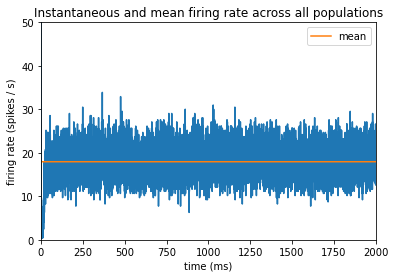

In [24]:
fig, ax = plt.subplots()
ax.plot(tsteps, rate)
ax.plot(tsteps, np.average(rate)*np.ones(len(tsteps)), label='mean')
ax.set_title('Instantaneous and mean firing rate across all populations')
ax.set_xlabel('time (ms)')
ax.set_ylabel('firing rate (spikes / s)')
ax.set_xlim(0, sim_params['t_sim'])
ax.set_ylim(0, 50)
ax.legend()

### 5.2 Raster plot of spiking activity for single area <a class="anchor" id="section_5_2"></a>
Fig. 3 (A-C) Raster plot of spiking activity of 3% of the neurons in area V1 (A), V2 (B), and FEF (C). Blue: excitatory neurons, red: inhibitory neurons. (D-F) Spiking statistics across all 32 areas for the respective populations shown as area-averaged box plots. Crosses: medians, boxes: interquartile range (IQR), whiskers extend to the most extremeobservat ions within 1.5×IQR beyond the IQR.

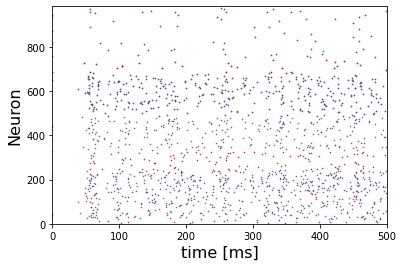

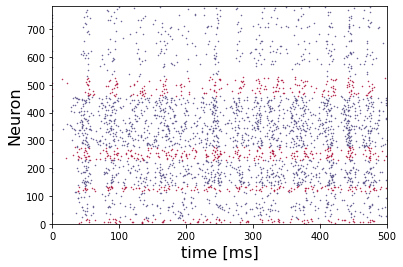

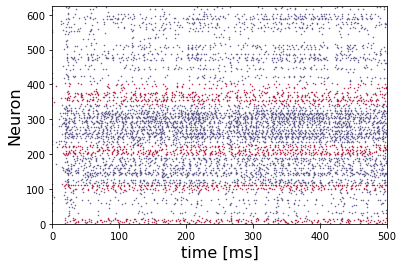

In [25]:
"""
Create raster display of a single area with populations stacked onto each other. Excitatory neurons in blue, inhibitory neurons in red.

Parameters
----------
area : string {area}
    Area to be plotted.
frac_neurons : float, [0,1]
    Fraction of cells to be considered.
t_min : float, optional
    Minimal time in ms of spikes to be shown. Defaults to 0 ms.
t_max : float, optional
    Minimal time in ms of spikes to be shown. Defaults to simulation time.
output : {'pdf', 'png', 'eps'}, optional
    If given, the function stores the plot to a file of the given format.
"""
t_min = 0.
t_max = 500.
areas = ['V1', 'V2', 'FEF']
frac_neurons = 1.
for area in areas:
    A.single_dot_display(area,  frac_neurons, t_min, t_max)

In [26]:
# load spike data
spike_data = A.spike_data

/tmp/ipykernel_12774/362875631.py:71: UserWarning:FixedFormatter should only be used together with FixedLocator


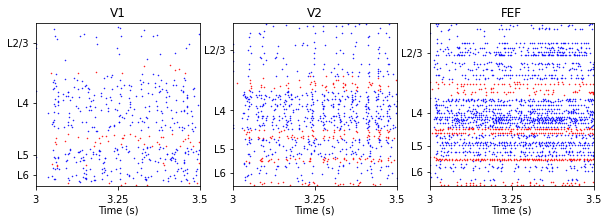

In [27]:
# plotting raster plot of spiking activity for single area
from matplotlib import gridspec
# axes = {}
# gs1 = gridspec.GridSpec(1, 3)
# # gs1.update(left=0.06, right=0.72, top=0.95, wspace=0.4, bottom=0.35)
# axes['A'] = plt.subplot(gs1[:1, :1], figsize=(16,9), gridspec_kw={'height_ratios': [1, 2]})
# axes['B'] = plt.subplot(gs1[:1, 1:2])
# axes['C'] = plt.subplot(gs1[:1, 2:])
f = plt.figure(figsize=(10,3))
sub = [131, 132, 133]

areas = ['V1', 'V2', 'FEF']
labels = ['A', 'B', 'C']

t_min = 0.
t_max = 500.
# t_min = 3000.
# t_max = 3500.

# icolor = myred
# ecolor = myblue

# frac_neurons = 0.03
frac_neurons = 0.3

for i, area in enumerate(areas):
    # ax = axes[labels[i]]
    # ax = plt.subplot()
    ax = f.add_subplot(sub[i])

    if area in spike_data:
        n_pops = len(spike_data[area])
        # Determine number of neurons that will be plotted for this area (for
        # vertical offset)
        offset = 0
        n_to_plot = {}
        for pop in M.structure[area]:
            n_to_plot[pop] = int(M.N[area][pop] * frac_neurons)
            offset = offset + n_to_plot[pop]
        y_max = offset + 1
        prev_pop = ''
        yticks = []
        yticklocs = []
        for jj, pop in enumerate(M.structure[area]):
            if pop[0:-1] != prev_pop:
                prev_pop = pop[0:-1]
                yticks.append('L' + population_labels[jj][0:-1])
                yticklocs.append(offset - 0.5 * n_to_plot[pop])
            ind = np.where(np.logical_and(
                spike_data[area][pop][:, 1] <= t_max, spike_data[area][pop][:, 1] >= t_min))
            pop_data = spike_data[area][pop][ind]
            pop_neurons = np.unique(pop_data[:, 0])
            neurons_to_ = np.arange(np.min(spike_data[area][pop][:, 0]), np.min(
                spike_data[area][pop][:, 0]) + n_to_plot[pop], 1)

            if pop.find('E') > (-1):
                pcolor = ecolor
            else:
                pcolor = icolor

            for kk in range(n_to_plot[pop]):
                spike_times = pop_data[pop_data[:, 0] == neurons_to_[kk], 1]

                _ = ax.plot(spike_times, np.zeros(len(spike_times)) +
                            offset - kk, '.', color=pcolor, markersize=1)
            offset = offset - n_to_plot[pop]
        y_min = offset
        ax.set_title(areas[i])
        ax.set_xlim([t_min, t_max])
        ax.set_ylim([y_min, y_max])
        ax.set_yticklabels(yticks)
        ax.set_yticks(yticklocs)
        ax.set_xlabel('Time (s)', labelpad=-0.1)
        ax.set_xticks([t_min, t_min + 250., t_max])
        ax.set_xticklabels([r'$3.$', r'$3.25$', r'$3.5$'])


### 5.3 Population-averaged firing rates <a class="anchor" id="section_5_3"></a>
Fig 3. (D) Population-averaged firing rates

In [30]:
# load data

# stationary firing rates
fn = os.path.join(data_path, label, 'Analysis', 'pop_rates.json')
with open(fn, 'r') as f:
    pop_rates = json.load(f)

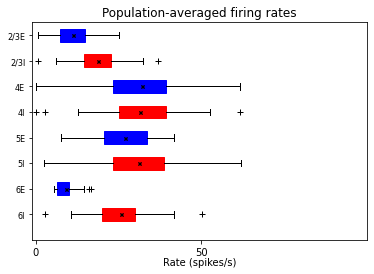

In [31]:
def set_boxplot_props(d):
    for i in range(len(d['boxes'])):
        if i % 2 == 0:
            d['boxes'][i].set_facecolor(icolor)
            d['boxes'][i].set_color(icolor)
        else:
            d['boxes'][i].set_facecolor(ecolor)
            d['boxes'][i].set_color(ecolor)
    plt.setp(d['whiskers'], color='k')
    plt.setp(d['fliers'], color='k', markerfacecolor='k', marker='+')
    plt.setp(d['medians'], color='none')
    plt.setp(d['caps'], color='k')
    plt.setp(d['means'], marker='x', color='k',
            markerfacecolor='k', markeredgecolor='k', markersize=3.)
    
# print("plotting Population rates")

rates = np.zeros((len(M.area_list), 8))
for i, area in enumerate(M.area_list):
    for j, pop in enumerate(M.structure[area][::-1]):
        rate = pop_rates[area][pop][0]
        if rate == 0.0:
            rate = 1e-5
        if area == 'TH' and j > 3:  # To account for missing layer 4 in TH
            rates[i][j + 2] = rate
        else:
            rates[i][j] = rate


rates = np.transpose(rates)
masked_rates = np.ma.masked_where(rates < 1e-4, rates)

# ax = axes['D']
ax = plt.subplot()
d = plt.boxplot(np.transpose(rates), vert=False,
               patch_artist=True, whis=1.5, showmeans=True)
set_boxplot_props(d)

ax.plot(np.mean(rates, axis=1), np.arange(
    1., len(M.structure['V1']) + 1., 1.), 'x', color='k', markersize=3)

ax.set_yticklabels(population_labels[::-1], size=8)
ax.set_yticks(np.arange(1., len(M.structure['V1']) + 1., 1.))
ax.set_ylim((0., len(M.structure['V1']) + .5))

x_max = 100.
ax.set_title("Population-averaged firing rates")
ax.set_xlim((-1., x_max))
ax.set_xlabel(r'Rate (spikes/s)', labelpad=-0.1)
ax.set_xticks([0., 50.])

### 5.4 Time-averaged population rates <a class="anchor" id="section_5_4"></a>

0 V1
1 V2
2 VP
3 V3
4 PIP
5 V3A
6 MT
7 V4t
8 V4
9 PO
10 VOT
11 DP
12 MIP
13 MDP
14 MSTd
15 VIP
16 LIP
17 PITv
18 PITd
19 AITv
20 MSTl
21 FST
22 CITv
23 CITd
24 7a
25 STPp
26 STPa
27 FEF
28 46
29 TF
30 TH
31 AITd
['23E', '23I', '4E', '4I', '5E', '5I', '6E', '6I']


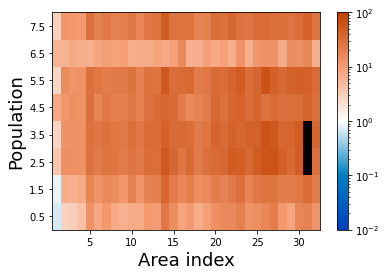

In [38]:
"""
Plot overview over time-averaged population rates encoded in colors
with areas along x-axis and populations along y-axis.

Parameters
----------
area_list : list, optional
   Specifies with areas are plotted in which order.
   Default to None, leading to plotting of  all areas ordered by architectural type.
output : {'pdf', 'png', 'eps'}, optional
    If given, the function stores the plot to a file of the given format.
"""
A.show_rates()

### 5.5 Average pairwise correlation coefficients of spiking activity <a class="anchor" id="section_5_5"></a>
Fig 5. (E) Average pairwise correlation coefficients of spiking activity

In [ ]:
# load data

# correlation coefficients
fn = os.path.join(data_path, label, 'Analysis', 'corrcoeff.json')
with open(fn, 'r') as f:
    corrcoeff = json.load(f)

In [ ]:
print("plotting Synchrony")

syn = np.zeros((len(M.area_list), 8))
for i, area in enumerate(M.area_list):
    for j, pop in enumerate(M.structure[area][::-1]):
        value = corrcoeff[area][pop]
        if value == 0.0:
            value = 1e-5
        if area == 'TH' and j > 3:  # To account for missing layer 4 in TH
            syn[i][j + 2] = value
        else:
            syn[i][j] = value


syn = np.transpose(syn)
masked_syn = np.ma.masked_where(syn < 1e-4, syn)

ax = axes['E']
d = ax.boxplot(np.transpose(syn), vert=False,
               patch_artist=True, whis=1.5, showmeans=True)
set_boxplot_props(d)

ax.plot(np.mean(syn, axis=1), np.arange(
    1., len(M.structure['V1']) + 1., 1.), 'x', color='k', markersize=3)

ax.set_yticklabels(population_labels[::-1], size=8)
ax.set_yticks(np.arange(1., len(M.structure['V1']) + 1., 1.))
ax.set_ylim((0., len(M.structure['V1']) + .5))
ax.set_xticks(np.arange(0.0, 0.601, 0.2))
ax.set_xlabel('Correlation coefficient', labelpad=-0.1)

### 5.6 Irregularity of spiking activity <a class="anchor" id="section_5_6"></a>
Fig 5. (F) Irregularity measured by revised local variation LvR averaged across neurons

In [ ]:
# load data

# local variance revised (LvR)
fn = os.path.join(data_path, label, 'Analysis', 'pop_LvR.json')
with open(fn, 'r') as f:
    pop_LvR = json.load(f)

In [ ]:
print("plotting Irregularity")

LvR = np.zeros((len(M.area_list), 8))
for i, area in enumerate(M.area_list):
    for j, pop in enumerate(M.structure[area][::-1]):
        value = pop_LvR[area][pop]
        if value == 0.0:
            value = 1e-5
        if area == 'TH' and j > 3:  # To account for missing layer 4 in TH
            LvR[i][j + 2] = value
        else:
            LvR[i][j] = value

LvR = np.transpose(LvR)
masked_LvR = np.ma.masked_where(LvR < 1e-4, LvR)

ax = axes['F']
d = ax.boxplot(np.transpose(LvR), vert=False,
               patch_artist=True, whis=1.5, showmeans=True)
set_boxplot_props(d)

ax.plot(np.mean(LvR, axis=1), np.arange(
    1., len(M.structure['V1']) + 1., 1.), 'x', color='k', markersize=3)
ax.set_yticklabels(population_labels[::-1], size=8)
ax.set_yticks(np.arange(1., len(M.structure['V1']) + 1., 1.))
ax.set_ylim((0., len(M.structure['V1']) + .5))


x_max = 2.9
ax.set_xlim((0., x_max))
ax.set_xlabel('Irregularity', labelpad=-0.1)
ax.set_xticks([0., 1., 2.])

axes['G'].spines['right'].set_color('none')
axes['G'].spines['left'].set_color('none')
axes['G'].spines['top'].set_color('none')
axes['G'].spines['bottom'].set_color('none')
axes['G'].yaxis.set_ticks_position("none")
axes['G'].xaxis.set_ticks_position("none")
axes['G'].set_xticks([])
axes['G'].set_yticks([])

### 5.7 Time series of area-averaged firing rates <a class="anchor" id="section_5_7"></a>
Area-averaged firing rates, shown as raw binned spike histograms with 1ms bin width (gray) and convolved histograms, with a Gaussian kernel (black) of optimal width.

In [ ]:
# load data

# time series of firing rates
rate_time_series = {}
for area in areas:
    fn = os.path.join(data_path, label,
                      'Analysis',
                      'rate_time_series_full',
                      'rate_time_series_full_{}.npy'.format(area))
    rate_time_series[area] = np.load(fn)

# time series of firing rates convolved with a kernel
rate_time_series_auto_kernel = {}
for area in areas:
    fn = os.path.join(data_path, label,
                      'Analysis',
                      'rate_time_series_auto_kernel',
                      'rate_time_series_auto_kernel_{}.npy'.format(area))
    rate_time_series_auto_kernel[area] = np.load(fn)

In [ ]:
print("Plotting rate time series")
pos = axes['G'].get_position()
ax = []
h = pos.y1 - pos.y0
w = pos.x1 - pos.x0
ax.append(pl.axes([pos.x0, pos.y0, w, 0.28 * h]))
ax.append(pl.axes([pos.x0, pos.y0 + 0.33 * h, w, 0.28 * h]))
ax.append(pl.axes([pos.x0, pos.y0 + 0.67 * h, w, 0.28 * h]))

colors = ['0.5', '0.3', '0.0']

t_min = 500.
t_max = 10500.
time = np.arange(500., t_max)
for i, area in enumerate(areas[::-1]):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].yaxis.set_ticks_position("left")
    ax[i].xaxis.set_ticks_position("none")

    binned_spikes = rate_time_series[area][np.where(
        np.logical_and(time >= t_min, time < t_max))]
    ax[i].plot(time, binned_spikes, color=colors[0], label=area)
    rate = rate_time_series_auto_kernel[area]
    ax[i].plot(time, rate, color=colors[2], label=area)
    ax[i].set_xlim((500., t_max))

    ax[i].text(0.8, 0.7, area, transform=ax[i].transAxes)

    if i > 0:
        ax[i].spines['bottom'].set_color('none')
        ax[i].set_xticks([])
        ax[i].set_yticks([0., 30.])
    else:
        ax[i].set_xticks([1000., 5000., 10000.])
        ax[i].set_xticklabels([r'$1.$', r'$5.$', r'$10.$'])
        ax[i].set_yticks([0., 5.])
    if i == 1:
        ax[i].set_ylabel(r'Rate (spikes/s)')

ax[0].set_xlabel('Time (s)', labelpad=-0.05)

Go back to [Notebook structure](#toc)